In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, confusion_matrix, roc_curve, auc
)

np.random.seed(42)

In [20]:
# --- CELL 2: Load & Preprocess Data (Numerical Dataset) ---
DATASET_NAME = "TUANDROMD (Android Malware Dataset)"
DATASET_PATH = "Datasets/TUANDROMD.csv"
LABEL_COL = "Label"

# Load the dataset
raw_df = pd.read_csv(DATASET_PATH)
print(f"Dataset: {DATASET_NAME}")
print(f"Loaded from: {DATASET_PATH}")
print(f"Total samples (raw): {raw_df.shape[0]}")
print(f"Total columns (raw): {raw_df.shape[1]}")
print("Sample size: N/A (tabular numerical features, not images)")

# Clean data
print("\n--- Cleaning ---")
df = raw_df.copy()
print(f"Original shape: {df.shape}")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape}")
df = df.dropna()
print(f"After dropping missing values: {df.shape}")

# Encode labels
le = LabelEncoder()
df[LABEL_COL] = le.fit_transform(df[LABEL_COL])
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\n--- Dataset General Info ---")
print(f"Number of classes: {len(le.classes_)}")
print(f"Class labels & mapping: {class_mapping}")
print("Class counts (cleaned):")
print(df[LABEL_COL].value_counts())

# Feature extraction (tabular: features are dataset columns excluding label)
X_df = df.drop(columns=[LABEL_COL])
y = df[LABEL_COL].astype(int)
feature_names = list(X_df.columns)
print("\n--- Feature Extraction ---")
print(f"Number of extracted features: {X_df.shape[1]}")
print("Feature names (first 25):", feature_names[:25])
print("Feature names (last 5):", feature_names[-5:])
print(f"Raw feature matrix dimension: {X_df.shape}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
print(f"Scaled feature matrix dimension: {X_scaled.shape}")

# Split into Train/Validation/Test (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\n--- Split Sizes ---")
print(f"Train: {X_train.shape} | samples = {X_train.shape[0]}")
print(f"Validation: {X_val.shape} | samples = {X_val.shape[0]}")
print(f"Test: {X_test.shape} | samples = {X_test.shape[0]}")

Dataset: TUANDROMD (Android Malware Dataset)
Loaded from: Datasets/TUANDROMD.csv
Total samples (raw): 4465
Total columns (raw): 242
Sample size: N/A (tabular numerical features, not images)

--- Cleaning ---
Original shape: (4465, 242)
After removing duplicates: (663, 242)
After dropping missing values: (662, 242)

--- Dataset General Info ---
Number of classes: 2
Class labels & mapping: {'goodware': np.int64(0), 'malware': np.int64(1)}
Class counts (cleaned):
Label
0    531
1    131
Name: count, dtype: int64

--- Feature Extraction ---
Number of extracted features: 241
Feature names (first 25): ['ACCESS_ALL_DOWNLOADS', 'ACCESS_CACHE_FILESYSTEM', 'ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_LOCATION', 'ACCESS_COARSE_UPDATES', 'ACCESS_FINE_LOCATION', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_MTK_MMHW', 'ACCESS_NETWORK_STATE', 'ACCESS_PROVIDER', 'ACCESS_SERVICE', 'ACCESS_SHARED_DATA', 'ACCESS_SUPERUSER', 'ACCESS_SURFACE_FLINGER', 'ACCESS_WIFI_STATE', 'activityCalle

--- Linear Regression (Manual GD) Hyperparameters ---
optimizer: Batch Gradient Descent
learning_rate: 0.005
n_epochs: 2000
batch_size: None
L2 reg_lambda: 0.0001
max_grad_norm: 5.0
early_stopping: patience=50, min_delta=1e-08
Training Linear Regression (Manual Gradient Descent)...
Early stopping at epoch 404 | best_val_mse=0.036163


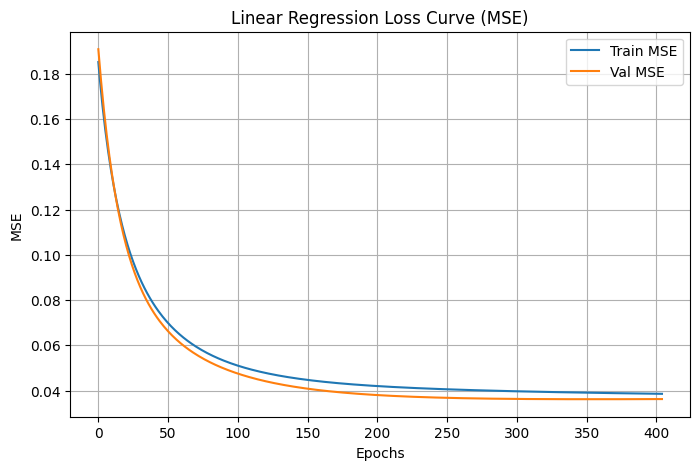

In [24]:
# --- CELL 3: Linear Regression (Manual Gradient Descent) as a Regressor ---
# Requirement: Linear regression & KNN as REGRESSORS on a numerical dataset.
# We train linear regression to predict the numeric label y in {0,1}.
# For classification-style reporting (accuracy/CM/ROC), we threshold the regressor output at 0.5.

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Add bias term
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_val_b = np.c_[np.ones((X_val.shape[0], 1)), X_val]
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Hyperparameters (Implementation Details)
learning_rate = 0.005   # smaller LR to prevent divergence
n_epochs = 2000
batch_size = None       # None => batch gradient descent
reg_lambda = 1e-4       # small L2 regularization for stability
optimizer = "Batch Gradient Descent"

# Stability helpers
max_grad_norm = 5.0     # gradient clipping
patience = 50           # early stopping patience on validation MSE
min_delta = 1e-8

print("--- Linear Regression (Manual GD) Hyperparameters ---")
print(f"optimizer: {optimizer}")
print(f"learning_rate: {learning_rate}")
print(f"n_epochs: {n_epochs}")
print(f"batch_size: {batch_size}")
print(f"L2 reg_lambda: {reg_lambda}")
print(f"max_grad_norm: {max_grad_norm}")
print(f"early_stopping: patience={patience}, min_delta={min_delta}")

# Ensure float64 for numerical stability
X_train_b = X_train_b.astype(np.float64)
X_val_b = X_val_b.astype(np.float64)
X_test_b = X_test_b.astype(np.float64)

# Initialize parameters
theta = np.zeros((X_train_b.shape[1], 1), dtype=np.float64)

y_train_vec = y_train.values.reshape(-1, 1).astype(np.float64)
y_val_vec = y_val.values.reshape(-1, 1).astype(np.float64)

train_loss_history = []
val_loss_history = []

m = X_train_b.shape[0]

best_theta = theta.copy()
best_val = np.inf
no_improve = 0

print("Training Linear Regression (Manual Gradient Descent)...")
for epoch in range(n_epochs):
    # Predictions
    y_hat = X_train_b.dot(theta)  # (m,1)

    # Gradient of MSE + L2 (do not regularize bias term)
    grad = (2.0 / m) * (X_train_b.T.dot(y_hat - y_train_vec))
    if reg_lambda > 0:
        reg = (2.0 * reg_lambda / m) * theta
        reg[0] = 0.0
        grad = grad + reg

    # Gradient clipping
    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_grad_norm:
        grad = grad * (max_grad_norm / (grad_norm + 1e-12))

    # Update
    theta = theta - learning_rate * grad

    # Track losses
    train_mse = mse_loss(y_train_vec, X_train_b.dot(theta))
    val_mse = mse_loss(y_val_vec, X_val_b.dot(theta))
    train_loss_history.append(train_mse)
    val_loss_history.append(val_mse)

    # Safety stop on numerical issues
    if not (np.isfinite(train_mse) and np.isfinite(val_mse)):
        print(f"Stopped early (non-finite loss) at epoch {epoch} | train_mse={train_mse} | val_mse={val_mse}")
        break

    # Early stopping on validation
    if val_mse < best_val - min_delta:
        best_val = val_mse
        best_theta = theta.copy()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} | best_val_mse={best_val:.6f}")
            break

# Restore best parameters
theta = best_theta

# Plot Loss Curves (Train & Validation)
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train MSE")
plt.plot(val_loss_history, label="Val MSE")
plt.title("Linear Regression Loss Curve (MSE)")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

# Predictions (raw regression scores)
y_pred_lr_raw = X_test_b.dot(theta).flatten()

# For classification-style reporting
# Use clipped scores for ROC stability; threshold at 0.5 for class predictions
y_pred_lr_score = np.clip(y_pred_lr_raw, 0.0, 1.0)
y_pred_lr_class = (y_pred_lr_score >= 0.5).astype(int)

In [25]:
# --- CELL 4: KNN Model ---
print("Training KNN Classifier...")
# Note: Using KNN Regressor is okay, but KNN Classifier is better for labels. 
# Keeping your original Regressor logic for consistency, but on clean data.
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn_raw = knn.predict(X_test)
y_pred_knn_class = (y_pred_knn_raw > 0.5).astype(int)


Training KNN Classifier...



--- Linear Regression (Manual GD) (Regressor) Results on TEST ---
Threshold for class prediction: 0.5
MSE: 0.066672
MAE: 0.186956
R2:  0.573659
Accuracy: 0.9254


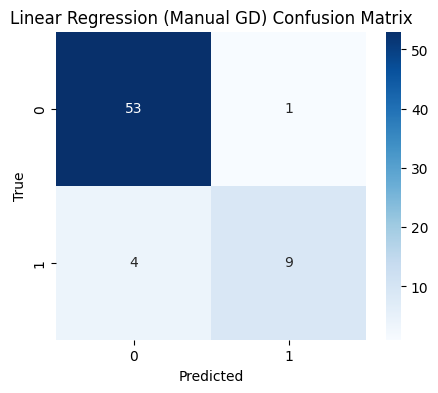

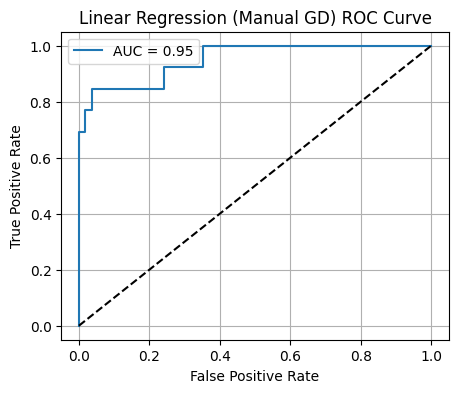


--- KNN Regressor (Regressor) Results on TEST ---
Threshold for class prediction: 0.5
MSE: 0.051940
MAE: 0.092537
R2:  0.667863
Accuracy: 0.9254


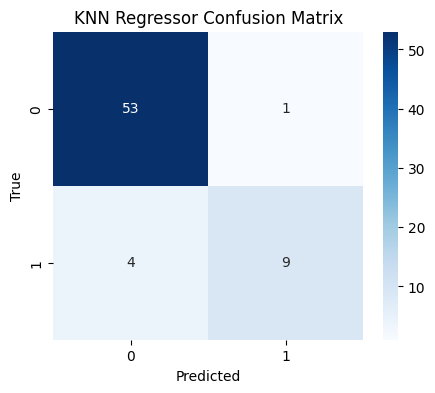

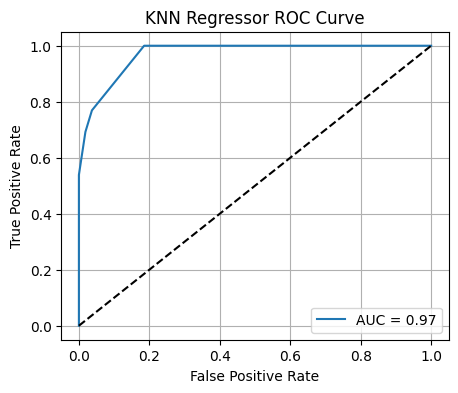

In [27]:
# --- CELL 5: Results & Visualization (Test Set) ---
# Note: Both models are REGRESSORS. We still report classification-style metrics by:
# - treating the regressor output as a score
# - thresholding at 0.5 to get predicted classes

THRESHOLD = 0.5

def evaluate_regressor(name, y_true, y_pred_raw, y_score_for_roc=None, threshold=0.5):
    """Evaluate a regressor on numeric labels y in {0,1}.

    - Regression metrics: MSE/MAE/R2 on raw predictions
    - Classification metrics: accuracy/CM/ROC using a thresholded score
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred_raw = np.asarray(y_pred_raw).astype(float)

    if y_score_for_roc is None:
        y_score_for_roc = y_pred_raw
    y_score_for_roc = np.asarray(y_score_for_roc).astype(float)

    # For ROC stability (keep scores in [0,1])
    y_score = np.clip(y_score_for_roc, 0.0, 1.0)
    y_pred_class = (y_score >= threshold).astype(int)

    print(f"\n--- {name} (Regressor) Results on TEST ---")
    print(f"Threshold for class prediction: {threshold}")

    # Regression metrics
    print(f"MSE: {mean_squared_error(y_true, y_pred_raw):.6f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred_raw):.6f}")
    print(f"R2:  {r2_score(y_true, y_pred_raw):.6f}")

    # Classification-style metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred_class):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate Linear Regression (manual GD)
evaluate_regressor(
    name="Linear Regression (Manual GD)",
    y_true=y_test,
    y_pred_raw=y_pred_lr_raw,
    y_score_for_roc=y_pred_lr_score,
    threshold=THRESHOLD,
)

# Evaluate KNN Regressor
# (y_pred_knn_raw is the regressor output; thresholding is done inside evaluate_regressor)
evaluate_regressor(
    name="KNN Regressor",
    y_true=y_test,
    y_pred_raw=y_pred_knn_raw,
    y_score_for_roc=y_pred_knn_raw,
    threshold=THRESHOLD,
)